## Do the abc in R cuz python abc packages suck
https://www.datacamp.com/community/blog/jupyter-notebook-r#gs.CkjgxoE

__NB:__ `conda install -c r rpy2=2.8.6 -f`
rpy2 needs to be a specific version to work in the ipython notebook.

## Do H' and lambda pods


In [229]:
%matplotlib inline
%load_ext rpy2.ipython

import os
import gimmeSAD
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import random
import glob
import scipy
from sklearn.metrics import mean_squared_error
from math import sqrt
from scipy.stats import linregress

GIMME_DIR = "/home/isaac/gimmeSAD/"
os.chdir(GIMME_DIR)
ONED_DIR = GIMME_DIR + "1d_sims/"
TWOD_DIR = GIMME_DIR + "2d_sims/"



The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython



In [179]:
## A function to return RMSE and R
def get_stats(tr, est):
    tr = np.array(tr).flatten()

    rms = sqrt(mean_squared_error(tr, est))
    r = np.corrcoef(np.vstack((tr, est)))[1,0]

    return rms, r

## Gather all the simulations into one huge simout file

In [186]:
def gather_simouts(SIMOUT_DIR):
    REF_TABLE = os.path.join(SIMOUT_DIR, "priors.txt")
    outfile = open(REF_TABLE, "w")

    ONEPER = True
    REGULARIZE = False
    DROPEQUILIBSIMS = True

    files = glob.glob(SIMOUT_DIR + "*/sumstats.txt")
    numsims = 0
    outfile.write(open(files[0]).readlines()[0])
    for f in files:
        lines = open(f).readlines()[1:]
        new_lines = []
        for line in lines:
            try:
                ## DO or don't regularlize the histograms
                if REGULARIZE:
                    hist = np.array([int(x) for x in line.split()[7:]])
                    if np.sum(hist):
                        tot = np.sum(hist)
                        hist = hist/float(tot)
                    tmp = line.split()[:7] + map(str,hist)
                    line = " ".join(tmp) + "\n"
                    new_lines.append(line)

                ## Do or don't drop all the extra sims at equilibrium
                if line.split()[3] == "1" and DROPEQUILIBSIMS:
                    pass
                else:
                    new_lines.append(line)
            except:
                pass
        lines = new_lines
        ## Only choose one step per simulation?
        if lines and ONEPER:
            lines = [random.choice(lines)]
        ## Don't write blanks
        if lines:
            numsims += len(lines)
            outfile.write("".join(lines))
            outfile.write("\n")
    outfile.close()
    print("Processed {} simulations.".format(numsims))

    ## Return the prior as a huge df
    PRIOR = pd.read_csv(REF_TABLE, sep="\t")
    print(PRIOR[:2])
    return PRIOR

ONED_PRIOR = gather_simouts(ONED_DIR)
TWOD_PRIOR = gather_simouts(TWOD_DIR)


Processed 62666 simulations.
      K         c   step    %equil  colrate  extrate  shannon  bin_0_0  \
0  3746  0.034413  10000  0.084891   0.0328  0.00850  1.93267      8.0   
1  3746  0.034413  20000  0.164709   0.0340  0.00865  2.33862     17.0   

   bin_0_1  bin_0_2   ...     bin_9_0  bin_9_1  bin_9_2  bin_9_3  bin_9_4  \
0      0.0      0.0   ...         0.0      0.0      0.0      0.0      0.0   
1      0.0      0.0   ...         0.0      0.0      0.0      0.0      0.0   

   bin_9_5  bin_9_6  bin_9_7  bin_9_8  bin_9_9  
0      0.0      0.0      0.0      0.0      0.0  
1      0.0      0.0      0.0      0.0      0.0  

[2 rows x 107 columns]


## Walk through and perform CV for each parameter using each data configuration.

In [ ]:
import rpy2.interactive as r
import rpy2.interactive.packages
r.packages.importr("abc")
abc = r.packages.packages.abc

models = ["Ma", "Mi", "Mai", "Mmi", "Mami"]
model_args = {"Ma":["shannon"],\
              "Mi":["bin_"+str(x) for x in range(0,10)],\
              "Mai":["shannon"] + ["bin_"+str(x) for x in range(0,10)],\
              "Mmi":["bin_{}_{}".format(x, y) for x in range(0,10) for y in range(0,10)],\
              "Mami":["shannon"] + ["bin_{}_{}".format(x, y) for x in range(0,10) for y in range(0,10)]}
params = ["K", "c", "%equil", "colrate", "extrate", "shannon"]

## Create the dict for holding results
results_dict = {}
for model in models:
    
    ## Select the right prior for each model
    if "m" in model:
        PRIOR = TWOD_PRIOR
    else:
        PRIOR = ONED_PRIOR

    results_dict[model] = {}
    for param in params:
        if "a" in model and param == "shannon":
            print("Skipping H' estimation for model - {}".format(model))
            continue
        print("Doing {} {}".format(model, param))
        cvresults = abc.cv4abc(PRIOR[param], PRIOR[model_args[model]], nval=1000, tols=robjects.r["c"](0.01, 0.05), method="loclinear")
        results_dict[model][param] = cvresults
        print(robjects.r["summary"](cvresults))


Doing Ma K
            P1
0.01 0.6437486
0.05 0.6428525

Doing Ma c
            P1
0.01 0.9962669
0.05 0.9891206

Doing Ma %equil
            P1
0.01 0.2803083
0.05 0.2744326

Doing Ma colrate
            P1
0.01 1.0137215
0.05 0.9788074

Doing Ma extrate
            P1
0.01 0.7348754
0.05 0.7304424

Skipping H' estimation for model - Ma
Doing Mi K
            P1
0.01 0.4551768
0.05 0.4483566

Doing Mi c
            P1
0.01 0.4120579
0.05 0.3936119

Doing Mi %equil
            P1
0.01 0.4839198
0.05 0.4647388

Doing Mi colrate
            P1
0.01 0.4069741
0.05 0.3965968

Doing Mi extrate
            P1
0.01 0.6334743
0.05 0.6433551

Doing Mi shannon
            P1
0.01 0.2364333
0.05 0.2265066

Doing Mai K
            P1
0.01 0.3315810
0.05 0.3283744

Doing Mai c
            P1
0.01 0.2753265
0.05 0.2716044

Doing Mai %equil
            P1
0.01 0.1940988
0.05 0.1950586

Doing Mai colrate
            P1
0.01 0.2753571
0.05 0.2745249

Doing Mai extrate
            P1
0.01 0.4753528
0.05

## Do a bunch of nasty rpy2 stuff to get the data out

In [192]:
from rpy2 import robjects
from rpy2.robjects import pandas2ri
pandas2ri.activate()

cv_dict = {}
for model in models:
    cv_dict[model] = {}
    for param in params:
        if "a" in model and param == "shannon":
            print("Skipping H' estimation for model - {}".format(model))
            continue
        cv_dict[model][param] = {}
        cvresults = results_dict[model][param]
        df_true = pandas2ri.ri2py(cvresults[cvresults.names.index('true')])
        df_est = pandas2ri.ri2py(cvresults[cvresults.names.index('estim')])
        tru = np.array(df_true).flatten()
        est = np.array(df_est).flatten()
        cv_dict[model][param]["true"] = tru
        cv_dict[model][param]["estim"] = est[:10]
        rms, r = get_stats(tru, est[:10])
        cv_dict[model][param]["rms"] = rms
        cv_dict[model][param]["r"] = r


Skipping H' estimation for model - Ma
Skipping H' estimation for model - Mai
Skipping H' estimation for model - Mami


In [222]:
print("Model\tParam\tRMS\t\tR")
for model in models:
    for param in params:
        try:
            rms = cv_dict[model][param]["rms"]
            r2 = cv_dict[model][param]["r"]**2
            rms = format(rms, ".3f")
            r2 = format(r2, ".3f")
            print("{}\t{}\t{}\t{}".format(model, param, rms, r2))
        except:
            pass
    print("")

Model	Param	RMS		R
Ma	K	2156.539	0.245
Ma	c	0.014	0.034
Ma	%equil	0.335	0.072
Ma	colrate	0.017	0.005
Ma	extrate	0.002	0.443

Mi	K	2413.314	0.413
Mi	c	0.007	0.782
Mi	%equil	0.290	0.451
Mi	colrate	0.007	0.609
Mi	extrate	0.001	0.813
Mi	shannon	0.303	0.841

Mai	K	1592.537	0.695
Mai	c	0.009	0.624
Mai	%equil	0.118	0.885
Mai	colrate	0.006	0.941
Mai	extrate	0.002	0.547

Mmi	K	2932.646	0.364
Mmi	c	0.011	0.727
Mmi	%equil	0.214	0.724
Mmi	colrate	0.005	0.961
Mmi	extrate	0.006	0.002
Mmi	shannon	0.335	0.648

Mami	K	1734.783	0.411
Mami	c	0.001	0.996
Mami	%equil	0.186	0.784
Mami	colrate	0.003	0.885
Mami	extrate	0.001	0.773



In [246]:
def plot_cv(model, cv_dict):
    f, axarr = plt.subplots(2, 3, figsize=(8,4), dpi=1000)
    axarr = [a for b in axarr for a in b]
    
    for param, ax in zip(params, axarr):
        if "a" in model and param == "shannon":
            continue
        print(model, param),

        x = cv_dict[model][param]["true"]
        y = cv_dict[model][param]["estim"]
        
        xmin = ymin = min(x)
        xlim = ylim = max(x)

        RUN_NAME = param
        
        ## linregress gets the rvalue and polyfit/poly1d gives us the fit function so we can draw the regression line
        res = linregress(x,y)
        fit = np.polyfit(x, y, 1)
        fit_fn = np.poly1d(fit)

        ## Calculate RMSE
        err=scipy.sqrt(sum((x-y)**2)/float(len(x)))
        RMSE = "RMSE {0:.4f}".format(cv_dict[model][param]["rms"])
        R2 = "R^2  {0:.4f}".format(cv_dict[model][param]["r"]**2)
        print(RMSE, R2)

        ## Plot the data and the regression line
        ax.scatter(x, y, marker="o", color='w', edgecolors='black')
        pts = np.linspace(xmin, xlim)
        ax.plot(pts, fit_fn(pts), '-r')

        ## Set titles and x/y limits
        ax.set_xlabel("True {}".format(param), fontsize=10)
        ax.set_ylabel("Estimated {}".format(param), fontsize=10)
        ax.set_title(RUN_NAME, fontsize=10)
        #ax.set_xlim(xmin, xlim)
        #ax.set_ylim(ymin, ylim)

        ## Plot the identity line
        ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")

        ## Add RMSE and R^2 to plots
        ax.text(0.2, 0.9, RMSE, ha='center', va='center', transform=ax.transAxes, color='r', size=8)
        ax.text(0.2, 0.78, R2, ha='center', va='center', transform=ax.transAxes, color='r', size=8)

        ## Remove the stupid tick spines
        ax.tick_params(axis=u'both', which=u'both',length=0)

    ## Give a little space between plots
    plt.subplots_adjust(wspace=0.4, hspace=0.6)
    plt.suptitle(model, fontsize=13)


('Ma', 'K') ('RMSE 2156.5391', 'R^2  0.2449')
('Ma', 'c') ('RMSE 0.0145', 'R^2  0.0337')
('Ma', '%equil') ('RMSE 0.3346', 'R^2  0.0720')
('Ma', 'colrate') ('RMSE 0.0174', 'R^2  0.0052')
('Ma', 'extrate') ('RMSE 0.0018', 'R^2  0.4427')
('Mi', 'K') ('RMSE 2413.3135', 'R^2  0.4129')
('Mi', 'c') ('RMSE 0.0066', 'R^2  0.7823')
('Mi', '%equil') ('RMSE 0.2897', 'R^2  0.4510')
('Mi', 'colrate') ('RMSE 0.0065', 'R^2  0.6089')
('Mi', 'extrate') ('RMSE 0.0012', 'R^2  0.8127')
('Mi', 'shannon') ('RMSE 0.3026', 'R^2  0.8406')


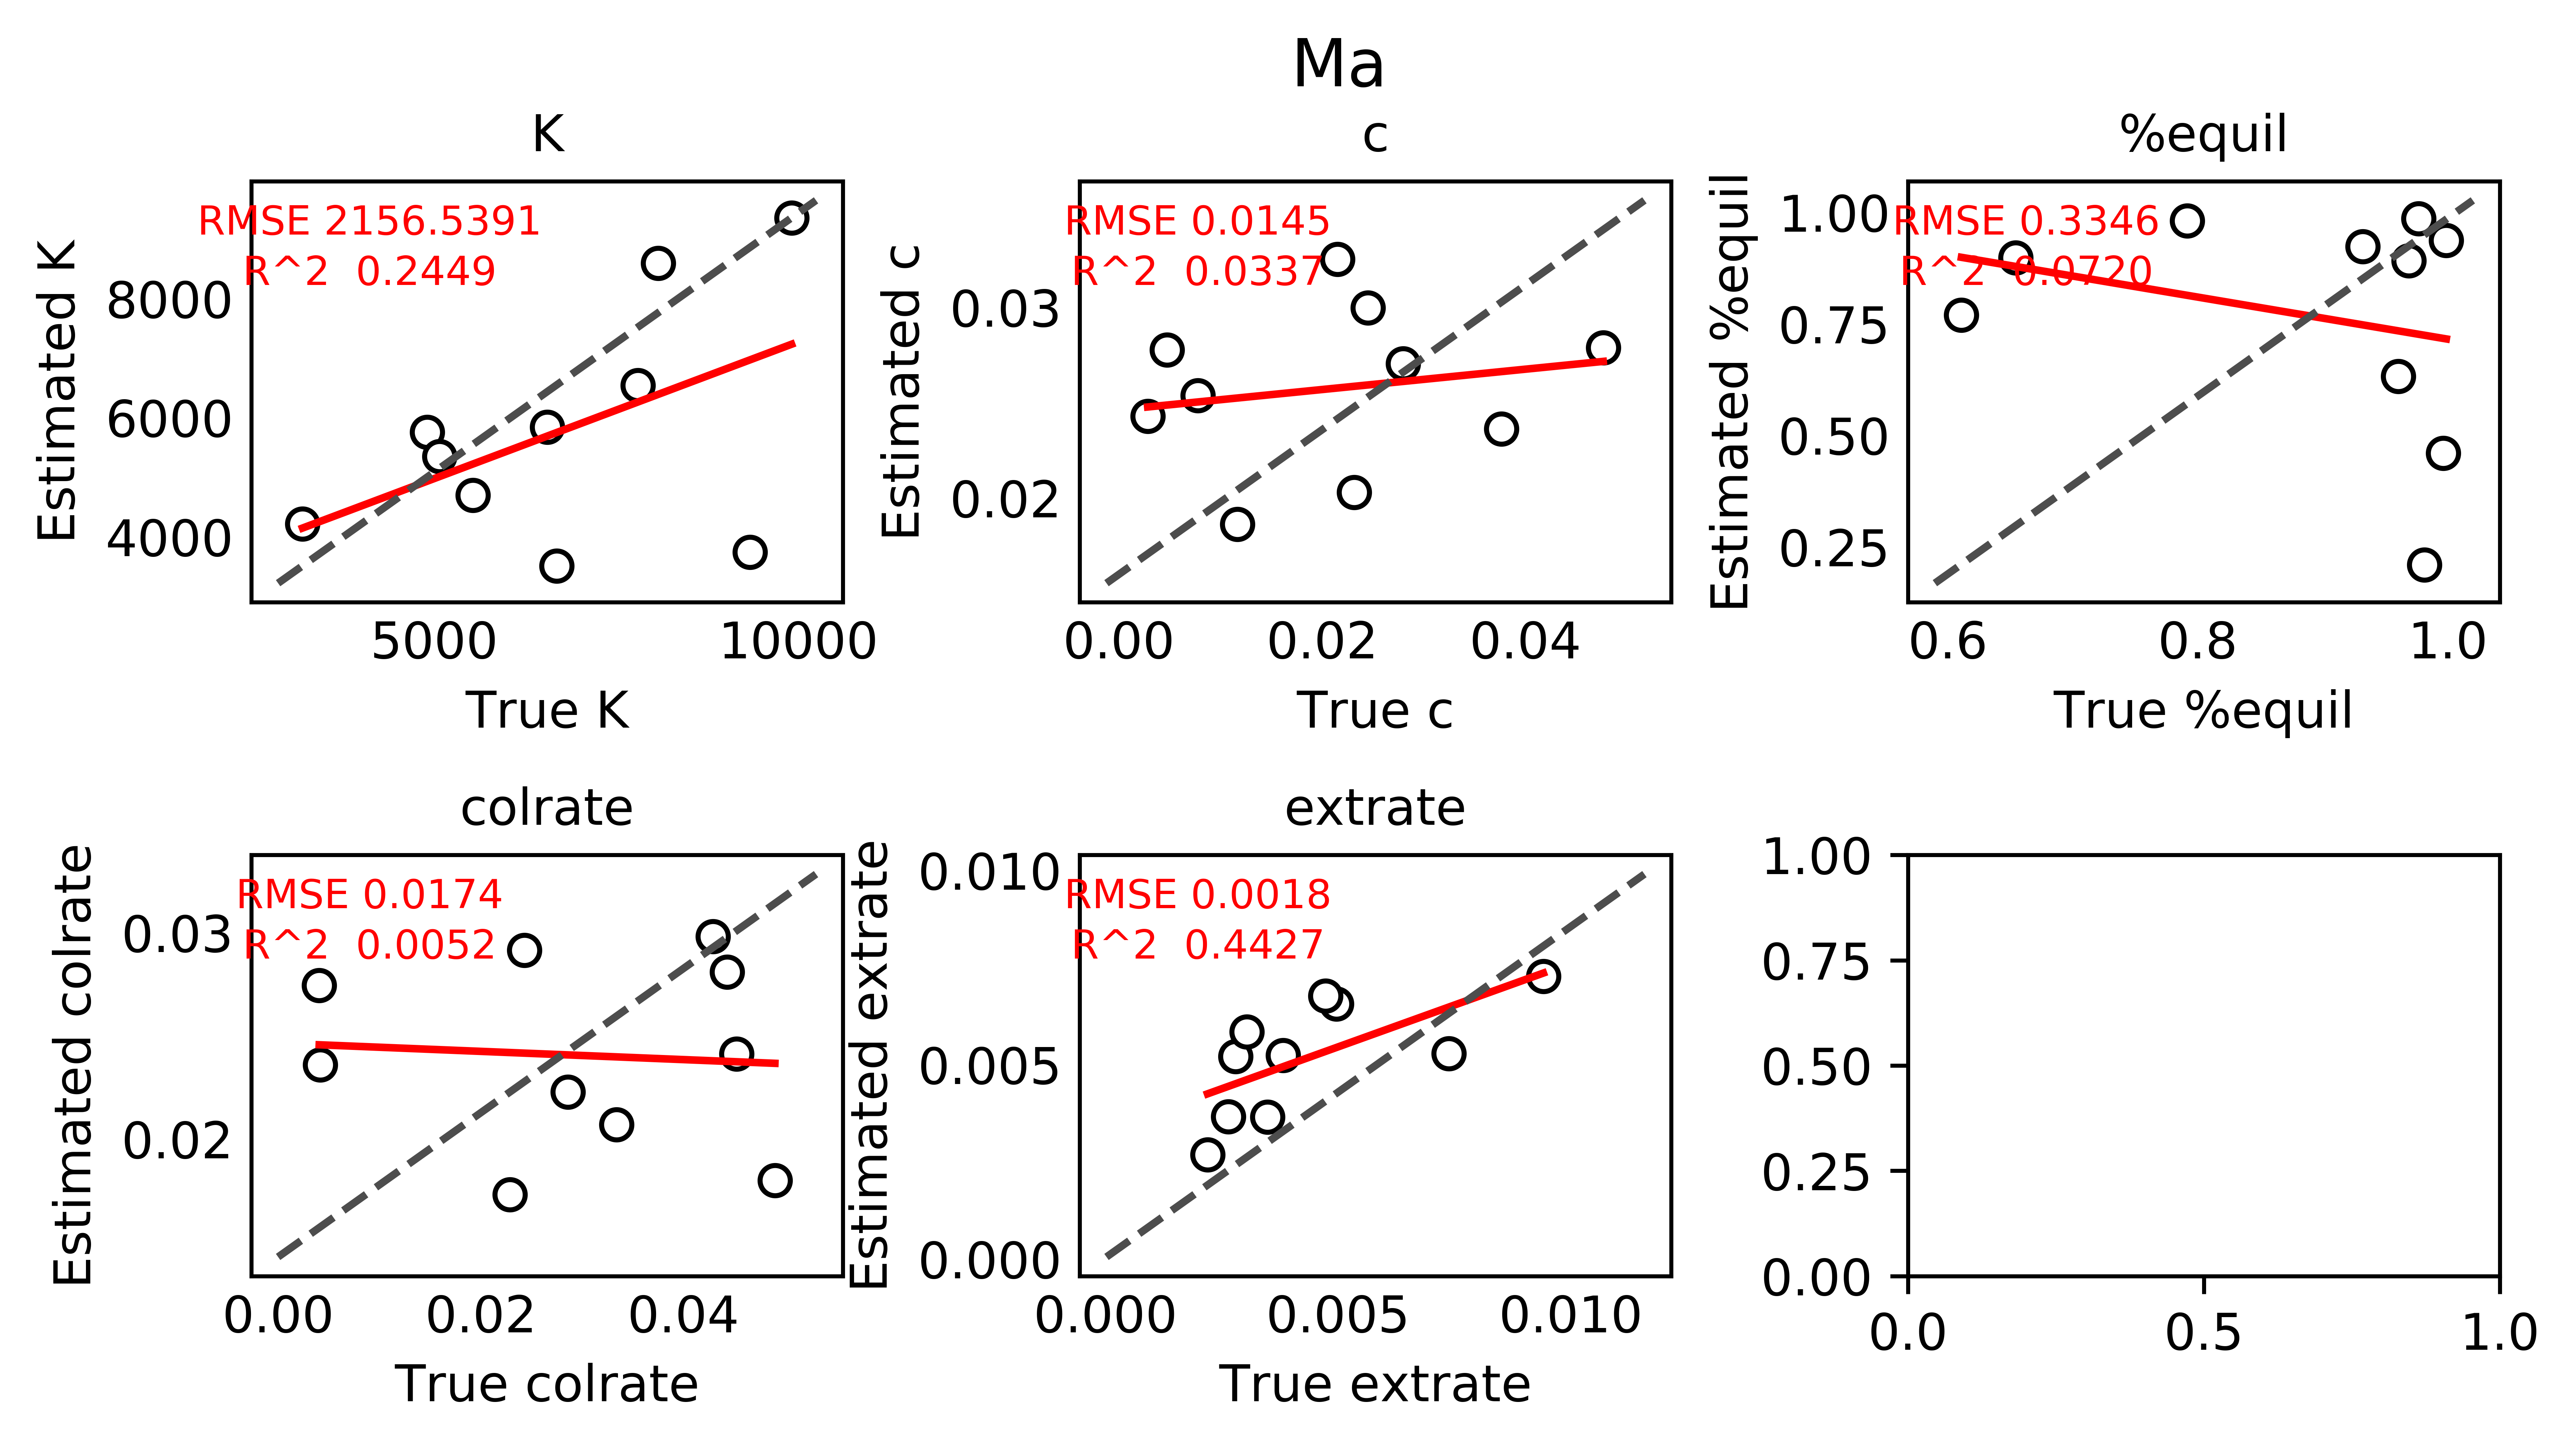

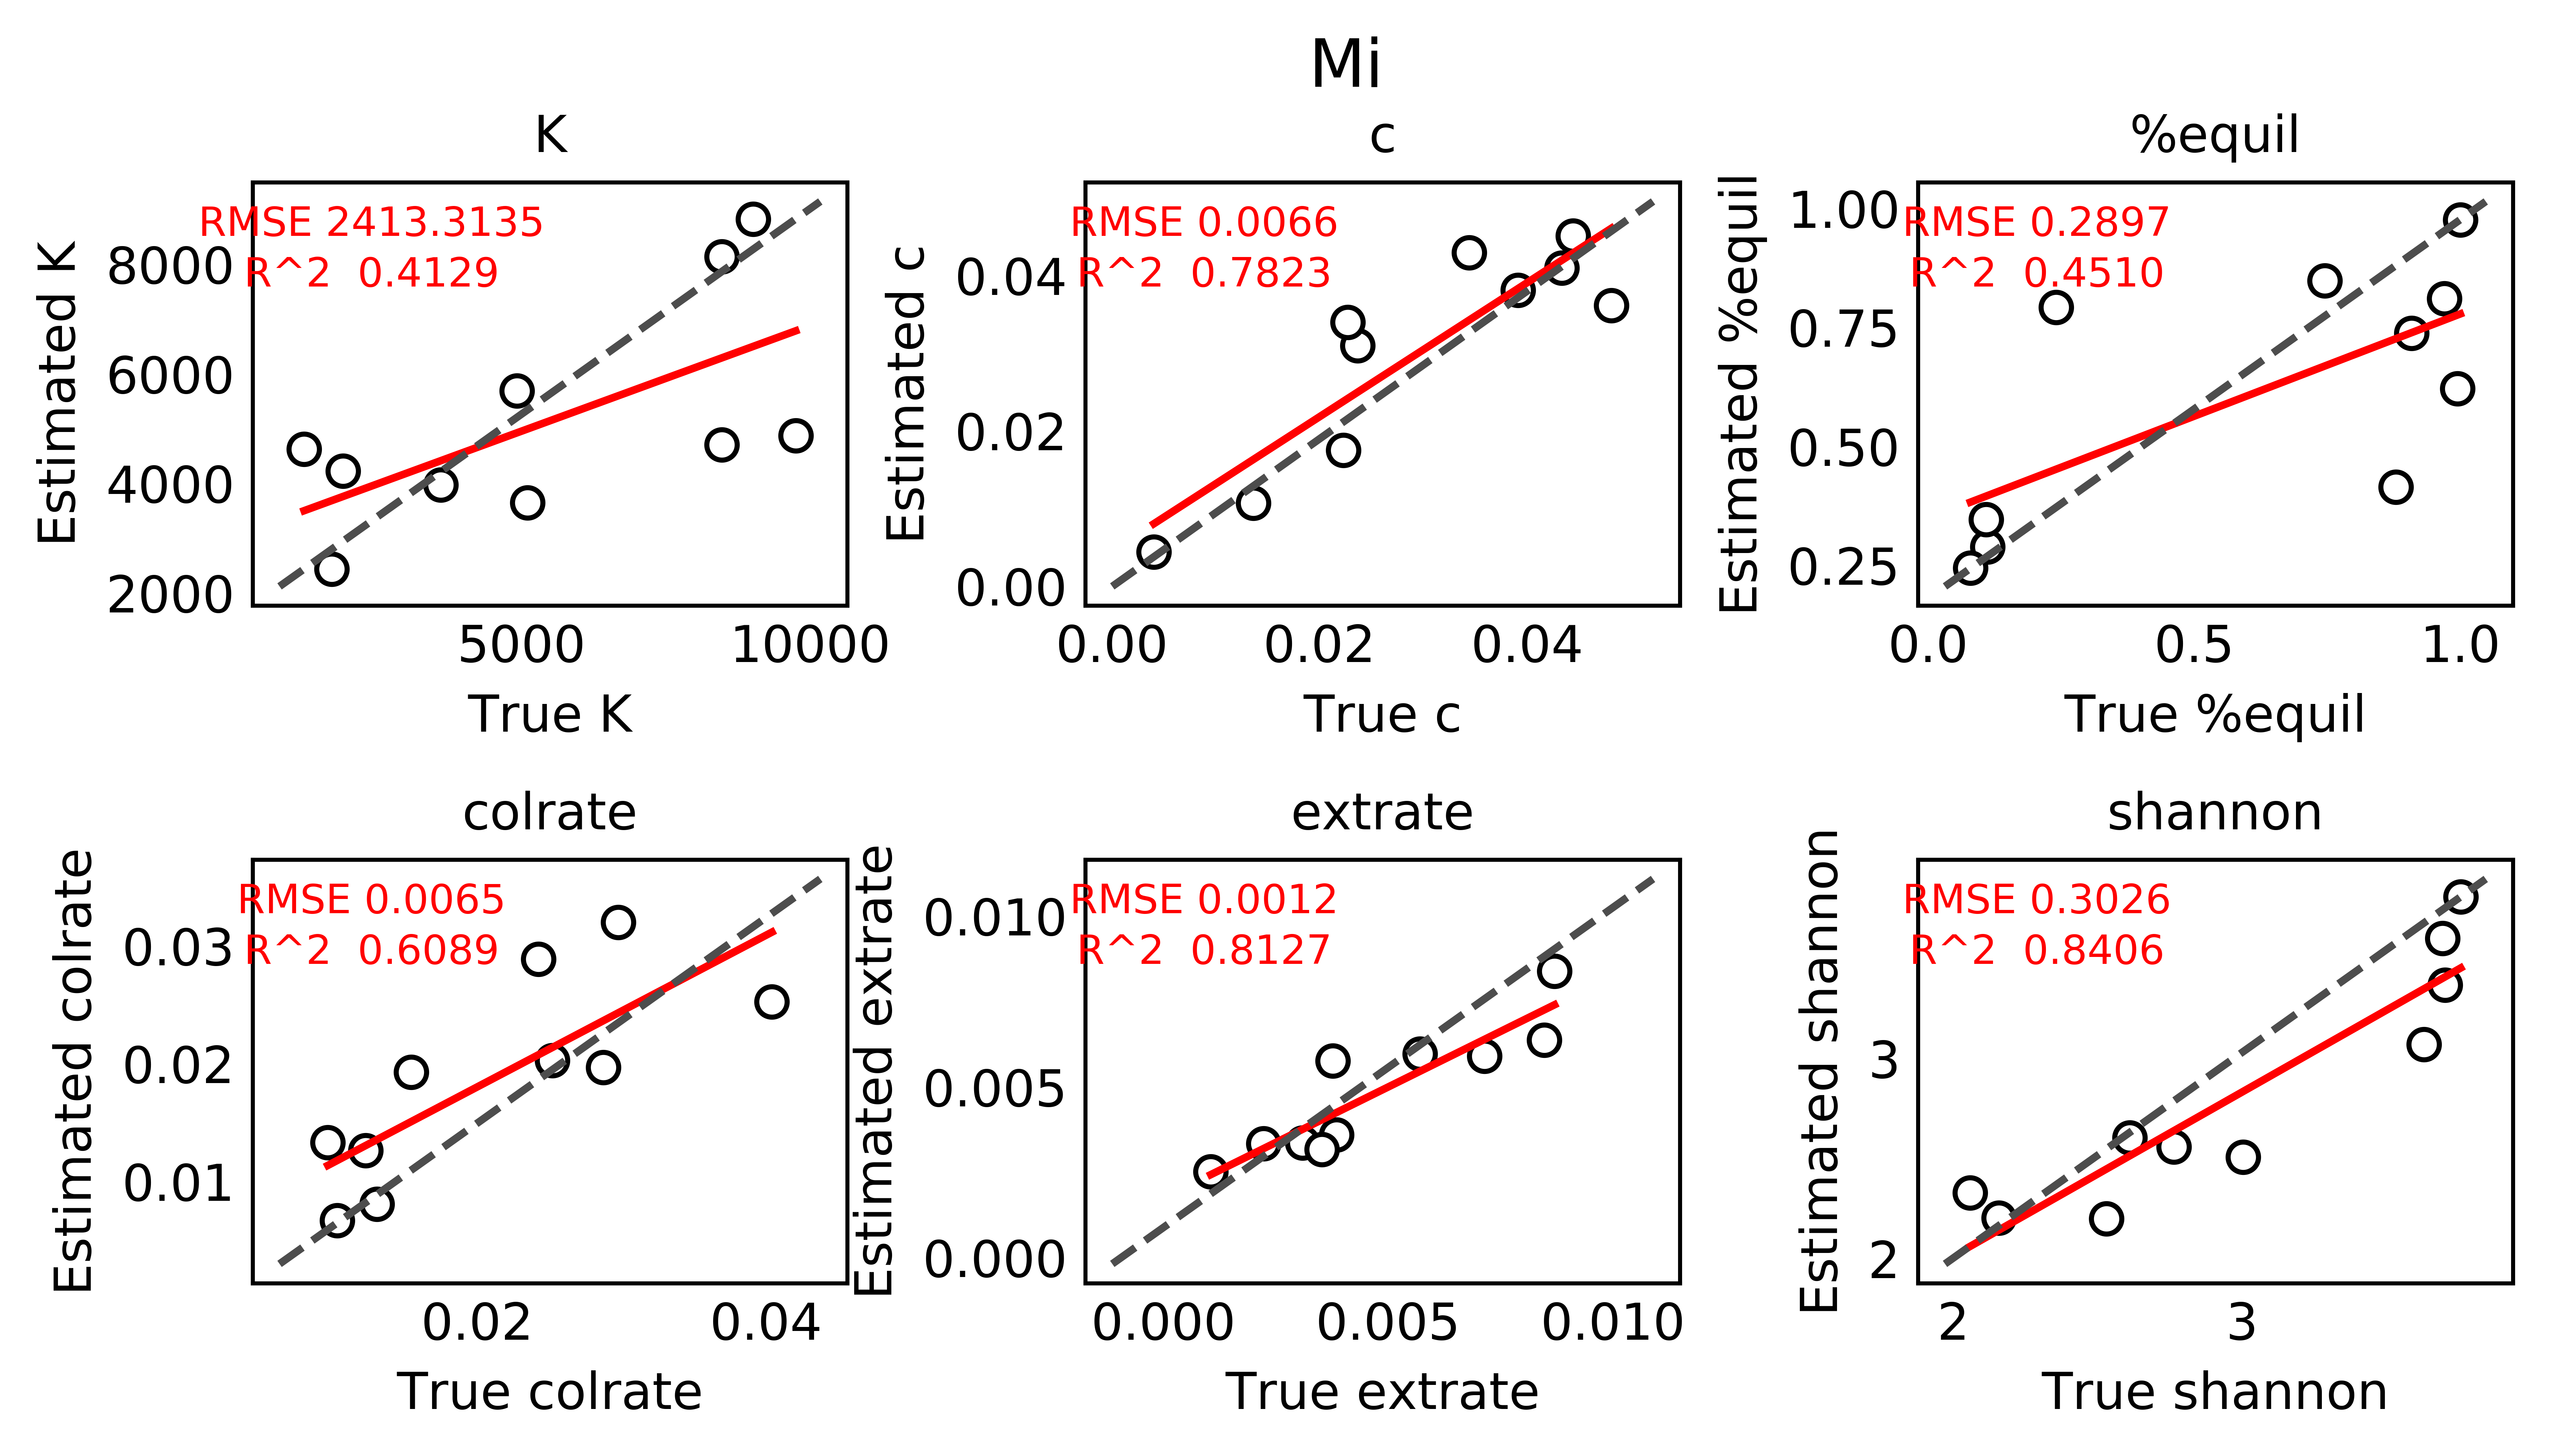

In [248]:
for model in ["Ma", "Mi"]:
    plot_cv(model, cv_dict)

## Everything below here is crap

# Scenario M(I) - 1D SGD
## Estimate H' using 1D π vector

## Estimate Λ using 1D π pi vector

# Scenario M(MI) - 2D SGD

# Scenario M(AMI) - 2D SGD & H'

Prediction errors for toy data
Doing Ma K
           P1
0.01 1.049726
0.05 1.026077

Doing Ma c
            P1
0.01 0.9894206
0.05 0.9391754

Doing Ma %equil
           P1
0.01 5.166433
0.05 4.635639

Doing Ma colrate
           P1
0.01 1.131167
0.05 1.112425

Doing Ma extrate
            P1
0.01 0.6154163
0.05 0.6359665

Skipping H' estimation for model - Ma
Doing Mi K
            P1
0.01 0.5387622
0.05 0.6091005

Doing Mi c
            P1
0.01 0.2045423
0.05 0.1664587

Doing Mi %equil
            P1
0.01 0.4951252
0.05 0.5074142

Doing Mi colrate
            P1
0.01 0.4026095
0.05 0.3773118

Doing Mi extrate
            P1
0.01 0.1989601
0.05 0.3307191

Doing Mi shannon
            P1
0.01 0.2072347
0.05 0.1879087

Doing Mai K
            P1
0.01 0.2776738
0.05 0.2095150

Doing Mai c
            P1
0.01 0.5255961
0.05 0.3998195

Doing Mai %equil
            P1
0.01 0.1260519
0.05 0.1117955

Doing Mai colrate
            P1
0.01 0.1765911
0.05 0.2231417

Doing Mai extrate
            P1
0.01 0.8608785
0.05 0.9572415

Skipping H' estimation for model - Mai
Doing Mmi K
            P1
0.01 1.2559241
0.05 0.5432039

Doing Mmi c
            P1
0.01 0.7936675
0.05 0.2866684

Doing Mmi %equil
            P1
0.01 0.3597958
0.05 0.3563132

Doing Mmi colrate
             P1
0.01 0.09534699
0.05 0.17672952

Doing Mmi extrate
           P1
0.01 15.78451
0.05  2.36977

Doing Mmi shannon
            P1
0.01 0.4453905
0.05 0.9180833

Doing Mami K
            P1
0.01 0.8146408
0.05 0.6199298

Doing Mami c
             P1
0.01 0.03459896
0.05 0.10983573

Doing Mami %equil
            P1
0.01 0.2210857
0.05 0.1317711

Doing Mami colrate
            P1
0.01 0.2577063
0.05 0.6711105

Doing Mami extrate
            P1
0.01 0.2276210
0.05 0.2185522

Skipping H' estimation for model - Mami

In [ ]:
## For the impatient, do them all at once forking w/ popen()

##This is broken

import rpy2.interactive as r
import rpy2.interactive.packages
import multiprocessing

r.packages.importr("abc")
abc = r.packages.packages.abc

models = ["Ma", "Mi", "Mai", "Mmi", "Mami"]
model_args = {"Ma":["shannon"],\
              "Mi":["bin_"+str(x) for x in range(0,10)],\
              "Mai":["shannon"] + ["bin_"+str(x) for x in range(0,10)],\
              "Mmi":["bin_{}_{}".format(x, y) for x in range(0,10) for y in range(0,10)],\
              "Mami":["shannon"] + ["bin_{}_{}".format(x, y) for x in range(0,10) for y in range(0,10)]}
params = ["K", "c", "%equil", "colrate", "extrate", "shannon"]

def call_abc(results_dict, model, param):
    cvresults = abc.cv4abc(PRIOR[param], PRIOR[model_args[model]], nval=10, tols=robjects.r["c"](0.01, 0.05), method="loclinear")
    results_dict[model][param] = cvresults
    return cvresults

## Create the dict for holding results
results_dict = {}
pids = {}
for model in models:
    
    ## Select the right prior for each model
    if "m" in model:
        PRIOR = TWOD_PRIOR
    else:
        PRIOR = ONED_PRIOR

    results_dict[model] = {}
    for param in params:
        if "a" in model and param == "shannon":
            print("Skipping H' estimation for model - {}".format(model))
            continue
        print("Doing {} {}".format(model, param))
        p = multiprocessing.Process(target=call_abc, args=(results_dict, model, ,))
        
        print(robjects.r["summary"](results_dict[model][param]))


Doing Ma K
           P1
0.01 1.049726
0.05 1.026077

Doing Ma c
            P1
0.01 0.9894206
0.05 0.9391754

Doing Ma %equil
           P1
0.01 5.166433
0.05 4.635639

Doing Ma colrate
           P1
0.01 1.131167
0.05 1.112425

Doing Ma extrate
            P1
0.01 0.6154163
0.05 0.6359665

Skipping H' estimation for model - Ma
Doing Mi K
            P1
0.01 0.5387622
0.05 0.6091005

Doing Mi c
            P1
0.01 0.2045423
0.05 0.1664587

Doing Mi %equil
            P1
0.01 0.4951252
0.05 0.5074142

Doing Mi colrate
            P1
0.01 0.4026095
0.05 0.3773118

Doing Mi extrate
            P1
0.01 0.1989601
0.05 0.3307191

Doing Mi shannon
            P1
0.01 0.2072347
0.05 0.1879087

Doing Mai K
            P1
0.01 0.2776738
0.05 0.2095150

Doing Mai c
            P1
0.01 0.5255961
0.05 0.3998195

Doing Mai %equil
            P1
0.01 0.1260519
0.05 0.1117955

Doing Mai colrate
            P1
0.01 0.1765911
0.05 0.2231417

Doing Mai extrate
            P1
0.01 0.8608785
0.05 0.957241